In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [166]:
#IMPORT DATA
df = pd.read_excel("BUPFIX.xlsx", index_col="ID")
df.head()

,delt,Refpres,Q,FVF,VISC,THICKNES,Pwf
ID,,,,,,,
1,0.00,6009,2500,1.21,0.92,23.0,5369.520
2,0.10,5769,2740,1.33,0.98,26.0,5431.052
3,0.21,5889,2680,1.09,0.74,24.2,5457.160
4,0.31,6189,2500,1.27,0.74,24.8,5500.167
5,0.52,6009,2440,1.45,0.80,21.8,5511.739


In [167]:
#Oil well data of the well on which PBU test is carried out
# Given Well data
tp = 4800 # hrs
Qo = 2500 # STB/day
rw = 0.401 # ft
ct = 8.72 * pow(10,-6) # 1/psi
H = 23 # ft
Pwf_det0 = 5369.52 #psia
Uo = 0.92 # cp
porosity = 0.21
Bo = 1.55 # rbl/STB
casing_id = 0.402 # ft

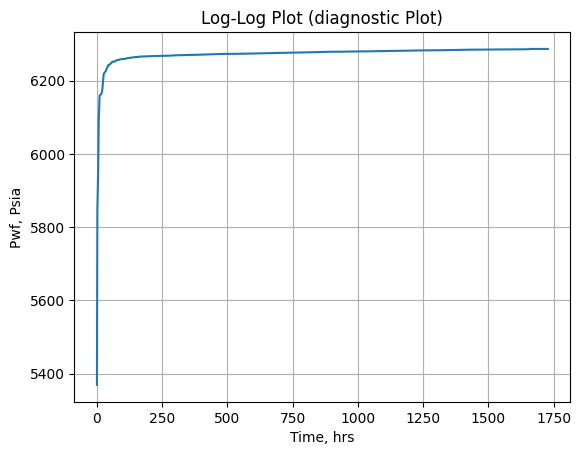

In [168]:
#Time vs Pwf Plot
plt.style.use('default')
plt.plot(df['delt'], df['Pwf'])
plt.title('Log-Log Plot (diagnostic Plot)')

plt.xlabel('Time, hrs')
plt.ylabel("Pwf, Psia")

plt.grid()

In [169]:
df['tp+delt/delt'] = (tp+df['delt'])/df['delt']
df.head()

,delt,Refpres,Q,FVF,VISC,THICKNES,Pwf,tp+delt/delt
ID,,,,,,,,
1,0.00,6009,2500,1.21,0.92,23.0,5369.520,inf
2,0.10,5769,2740,1.33,0.98,26.0,5431.052,4.800100e+04
3,0.21,5889,2680,1.09,0.74,24.2,5457.160,2.285814e+04
4,0.31,6189,2500,1.27,0.74,24.8,5500.167,1.548487e+04
5,0.52,6009,2440,1.45,0.80,21.8,5511.739,9.231769e+03


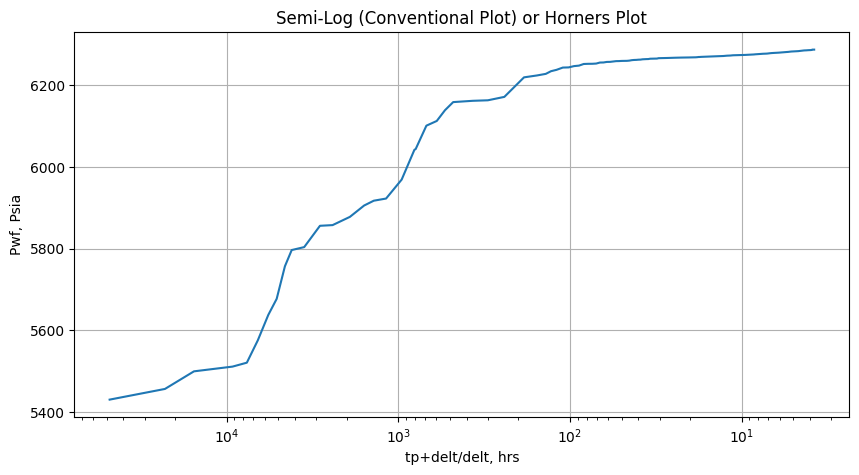

In [170]:
# Semi Log PLot of Pwf vs  tp+delt/delt
plt.style.use('default')
plt.figure(figsize=(10,5))
plt.semilogx(df['tp+delt/delt'], df['Pwf'])
plt.gca().invert_xaxis()
plt.title('Semi-Log (Conventional Plot) or Horners Plot')

plt.xlabel('tp+delt/delt, hrs')
plt.ylabel("Pwf, Psia")

plt.grid()

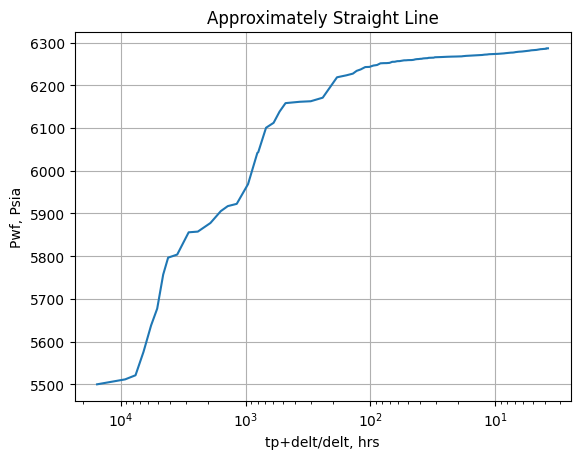

In [171]:
# Straight Line Part
df_SL = df.iloc[3:, :]

plt.style.use('default')
plt.semilogx(df_SL['tp+delt/delt'], df_SL['Pwf'],markevery= [3280])
plt.gca().invert_xaxis()
plt.title('Approximately Straight Line')

plt.xlabel('tp+delt/delt, hrs')
plt.ylabel("Pwf, Psia")

plt.grid()

In [172]:
# Slope From the above straight Line
m = -(6025-6053)/(np.log10(31)-np.log10(24.68))
print("The average Permeability obtained is: {} m", (m))


The average Permeability obtained is: {} m 282.78104276101004


In [173]:
# Calculating Permeability
df['k'] = (162.6*df['Q']*Bo*df['VISC'])/(m*H)

In [174]:
# Getting P1hr from the semilog plot
P1hr = 5971 # Psia
df['skin'] = 1.151*((P1hr - Pwf_det0)/m - np.log10((df['k'])/(porosity*df['VISC']*ct*rw*rw)) + 3.23)

In [175]:
df.columns

Index(['delt', 'Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf',
       'tp+delt/delt', 'k', 'skin'],
      dtype='object')

In [176]:
df.head()

,delt,Refpres,Q,FVF,VISC,THICKNES,Pwf,tp+delt/delt,k,skin
ID,,,,,,,,,,
1,0.00,6009,2500,1.21,0.92,23.0,5369.520,inf,89.125494,-3.637359
2,0.10,5769,2740,1.33,0.98,26.0,5431.052,4.800100e+04,104.052076,-3.683181
3,0.21,5889,2680,1.09,0.74,24.2,5457.160,2.285814e+04,76.849426,-3.672113
4,0.31,6189,2500,1.27,0.74,24.8,5500.167,1.548487e+04,71.687897,-3.637359
5,0.52,6009,2440,1.45,0.80,21.8,5511.739,9.231769e+03,75.640419,-3.625216


In [177]:
df.columns

Index(['delt', 'Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf',
       'tp+delt/delt', 'k', 'skin'],
      dtype='object')

In [178]:
df.drop(columns = (['delt', 'tp+delt/delt', 'skin']), inplace = True)

<Axes: >

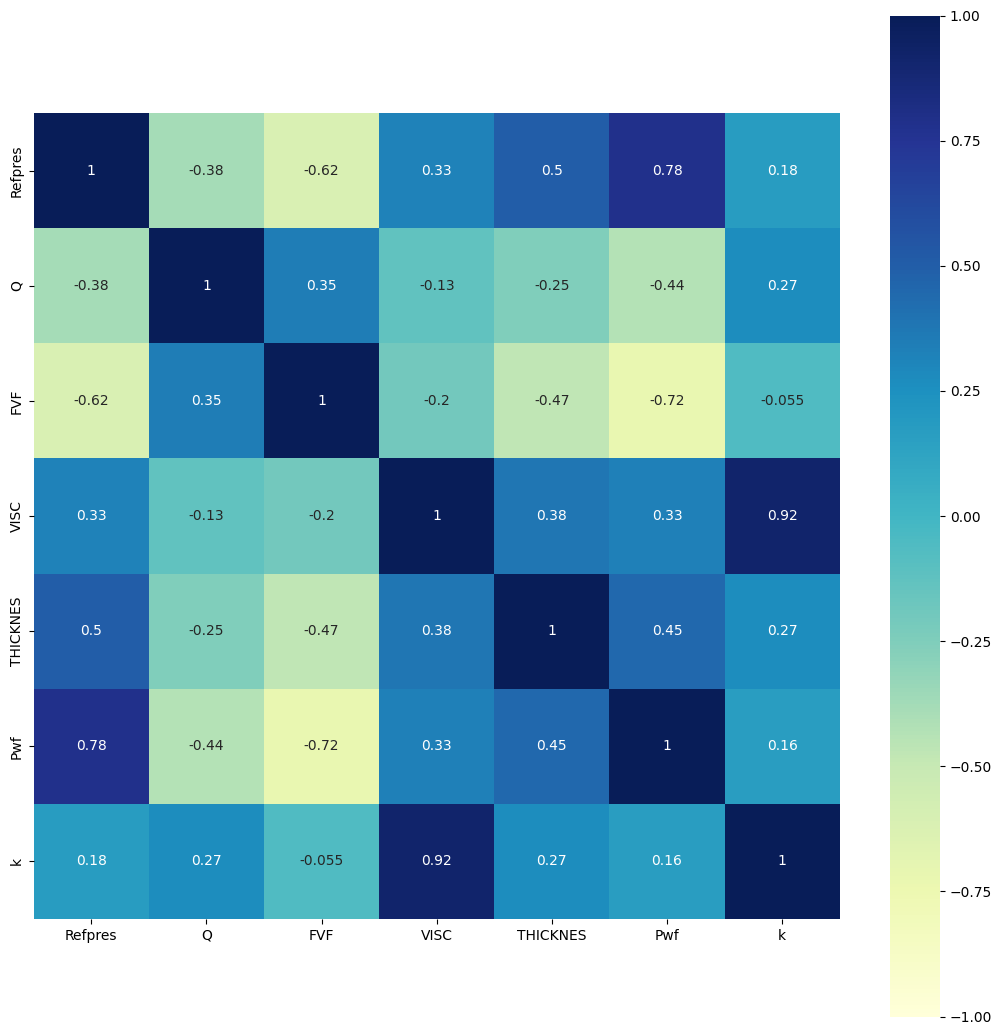

In [179]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), cmap='YlGnBu', cbar='False', vmin=-1, vmax=1, annot=True, square=True)

In [180]:
X = df.drop(columns="k")
y = df.k

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 6), (101, 6), (400,), (101,))

In [181]:
# Training
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from jcopml.tuning import random_search_params as rsp

In [182]:
# Create a polynomial feature transformer
poly = PolynomialFeatures(degree=2, include_bias=False)

In [183]:
lgbm = lgb.LGBMRegressor()

In [184]:
X_train.columns

Index(['Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf'], dtype='object')

In [185]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [186]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMRegressor(n_jobs=-1, random_state=42))
])


model_LG = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_LG.fit(X_train, y_train)

print(model_LG.best_params_)
print(model_LG.score(X_train, y_train), model_LG.best_score_, model_LG.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9835
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 83
[LightGBM] [Info] Start training from score 93.449471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [187]:
model_LG.score(X_train, y_train), model_LG.score(X_test, y_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


(0.9992076379212407, 0.9727763146974777)

In [188]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


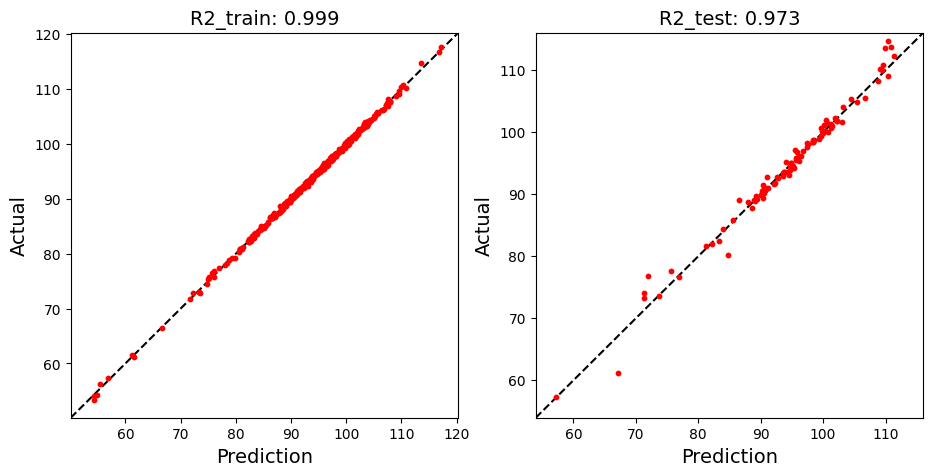

In [189]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_LG)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


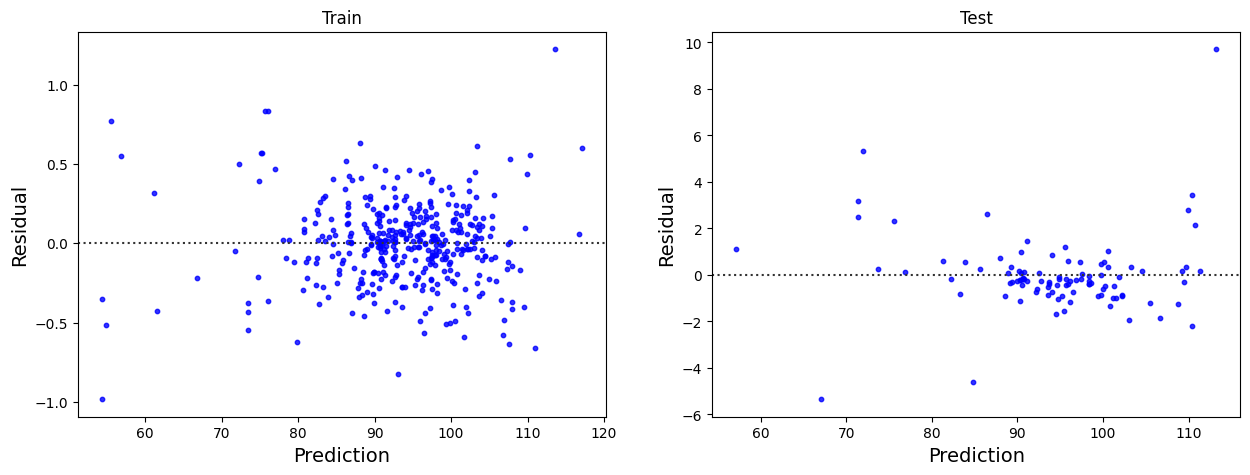

In [190]:
plot_residual(X_train, y_train, X_test, y_test, model_LG)

In [191]:
### Kesimpulan: polynomial memperbaiki model menjadi lebih baik
from jcopml.feature_importance import  mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease

In [192]:
# Prediction
X_train.iloc[:1]

,Refpres,Q,FVF,VISC,THICKNES,Pwf
ID,,,,,,
387,6297,2221,0.919,1.04,25.85,6282.869


In [193]:
X_pred = pd.DataFrame([[6009, 2500, 1.21, 0.92, 23, 5369.520]], columns=X_train.columns)
X_pred

,Refpres,Q,FVF,VISC,THICKNES,Pwf
0,6009,2500,1.21,0.92,23,5369.52


In [194]:
model_LG.predict(X_pred)

[LightGBM] [Warning] Unknown parameter: gamma


array([86.46835357])

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown param

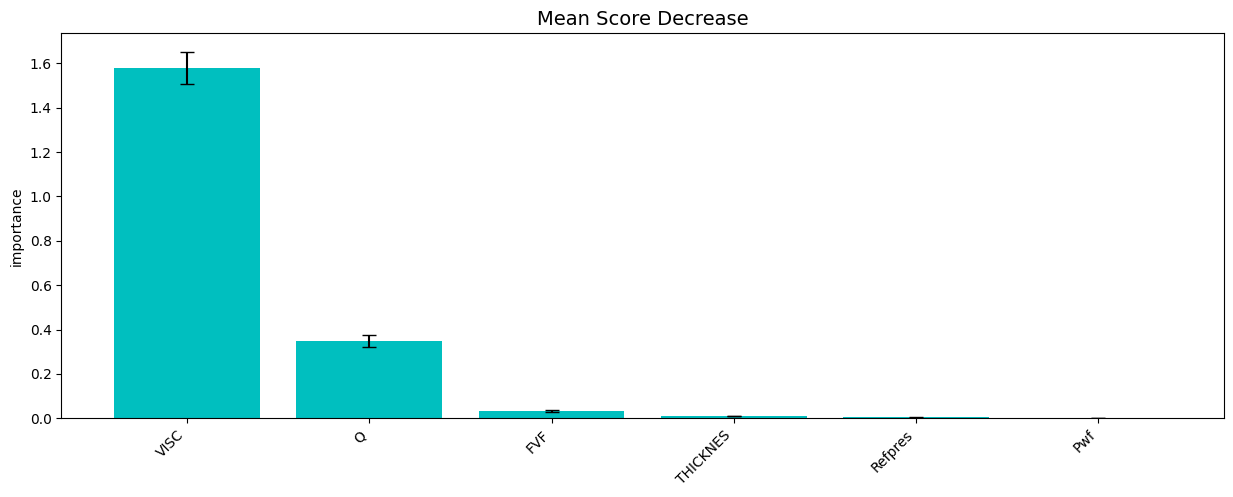

In [195]:
df_imp = mean_score_decrease(X_train, y_train, model_LG, plot=True, topk=10)

In [196]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMRegressor(n_jobs=-1, random_state=42))
])


model_MAE = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring= 'neg_mean_absolute_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_MAE.fit(X_train, y_train)

print(model_MAE.best_params_)
print(model_MAE.score(X_train, y_train), model_MAE.best_score_, model_MAE.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 6
[LightGBM] [Info] Start training from score 93.449471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [197]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMRegressor(n_jobs=-1, random_state=42))
])


model_MSE = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring= 'neg_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_MSE.fit(X_train, y_train)

print(model_MSE.best_params_)
print(model_MSE.score(X_train, y_train), model_MSE.best_score_, model_MSE.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 6
[LightGBM] [Info] Start training from score 93.449471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [198]:
save_model(model_LG, "Predict_Effective-Oil-Permeability_Ko")

Model is pickled as model/Predict_Effective-Oil-Permeability_Ko


In [199]:
K_test = model_LG.predict(X_test)
K_train = model_LG.predict(X_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


In [200]:
load_model('model/Predict_Effective-Oil-Permeability_Ko')

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures())]),
                                                                               ['Refpres',
                                                                                'Q',
                                                                                'FVF',
                                                                                'VISC',
                                                                                'THICKNES',
                                                                                'Pwf'])])),
                                             ('algo',
                                              LGBMRegressor(n_jobs=-1,
                                                            random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__colsam...
                                        'algo__n_estimators': Integer(low=100, high=200),
                                        'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
                                        'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
                                        'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
                                        'prep__numeric__poly__degree': Integer(low=1, high=3),
                                        'prep__numeric__poly__interaction_only': [True,
                                                                                  False]},
                   random_state=42, verbose=1)

In [201]:
X_train.head()

,Refpres,Q,FVF,VISC,THICKNES,Pwf
ID,,,,,,
387,6297,2221,0.919,1.040,25.85,6282.869
20,6189,2800,1.210,0.800,25.40,6041.700
323,6294,2248,0.922,1.211,25.82,6280.723
333,6309,2269,0.970,1.172,25.31,6281.219
57,6309,2479,0.928,1.121,25.64,6261.994


In [202]:
df.columns

Index(['Refpres', 'Q', 'FVF', 'VISC', 'THICKNES', 'Pwf', 'k'], dtype='object')

In [203]:
input_variable_test = df.drop(columns = 'k')

In [204]:
input_variable_test.head()

,Refpres,Q,FVF,VISC,THICKNES,Pwf
ID,,,,,,
1,6009,2500,1.21,0.92,23.0,5369.520
2,5769,2740,1.33,0.98,26.0,5431.052
3,5889,2680,1.09,0.74,24.2,5457.160
4,6189,2500,1.27,0.74,24.8,5500.167
5,6009,2440,1.45,0.80,21.8,5511.739


In [205]:
k_Predict_LGBM = model_LG.predict(input_variable_test)
df.insert(6, column = 'k_LGBM', value = k_Predict_LGBM, allow_duplicates = False)

[LightGBM] [Warning] Unknown parameter: gamma


In [206]:
df.head(10)

,Refpres,Q,FVF,VISC,THICKNES,Pwf,k_LGBM,k
ID,,,,,,,,
1,6009,2500,1.21,0.92,23.0,5369.520,86.468354,89.125494
2,5769,2740,1.33,0.98,26.0,5431.052,104.091283,104.052076
3,5889,2680,1.09,0.74,24.2,5457.160,71.985246,76.849426
4,6189,2500,1.27,0.74,24.8,5500.167,71.746542,71.687897
5,6009,2440,1.45,0.80,21.8,5511.739,75.078684,75.640419
6,5949,2260,0.97,0.86,23.6,5521.351,74.931456,75.314917
7,6249,2680,1.51,0.98,20.0,5576.045,102.209969,101.773564
8,6069,2320,1.51,0.68,21.2,5638.073,61.578439,61.132339
9,6129,2200,1.27,1.16,26.0,5677.326,98.827697,98.890548


In [207]:
df.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       492, 493, 494, 495, 496, 497, 498, 499, 500, 501],
      dtype='int64', name='ID', length=501)

In [208]:
df.reset_index(inplace=True)
df

,ID,Refpres,Q,FVF,VISC,THICKNES,Pwf,k_LGBM,k
0,1,6009,2500,1.210,0.920,23.00,5369.520,86.468354,89.125494
1,2,5769,2740,1.330,0.980,26.00,5431.052,104.091283,104.052076
2,3,5889,2680,1.090,0.740,24.20,5457.160,71.985246,76.849426
3,4,6189,2500,1.270,0.740,24.80,5500.167,71.746542,71.687897
4,5,6009,2440,1.450,0.800,21.80,5511.739,75.078684,75.640419
...,...,...,...,...,...,...,...,...,...
496,497,6306,2272,0.910,1.139,25.94,6286.409,100.253586,100.278115
497,498,6303,2224,0.943,1.076,25.94,6286.409,92.703113,92.730194
498,499,6306,2278,1.000,1.067,25.37,6286.417,95.406249,94.187279
499,500,6300,2212,0.949,1.061,25.70,6286.417,90.952299,90.944119


In [209]:
def get_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2.0)) 

def get_rel_l2_error(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred, 2) / np.linalg.norm(y_true, 2)

In [210]:
X1 = df.ID
y1 = df.k
y2 = df.k_LGBM

Text(0, 0.5, 'Permeability')

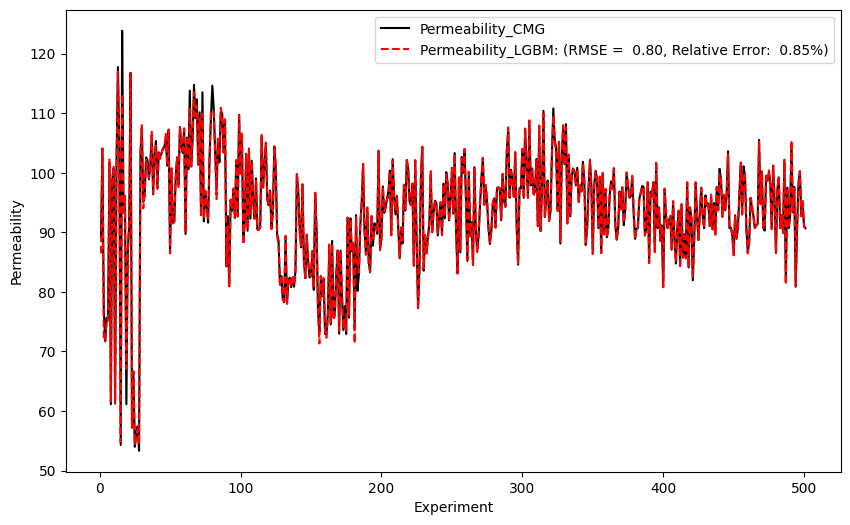

In [211]:
fig = plt.figure(figsize= (10, 6))
ax = plt.axes()

rmse_XG = get_rmse(df['k'], df['k_LGBM']) 
l2_XG = get_rel_l2_error(df['k'], df['k_LGBM']) * 100

ax.plot(X1, y1, 'k-', label = 'Permeability_CMG')
ax.plot(X1, y2, 'r--', label = f'Permeability_LGBM: (RMSE = {rmse_XG: .2f}, Relative Error: {l2_XG: .2f}%)')

ax.legend()
plt.xlabel('Experiment')
plt.ylabel('Permeability')